In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [195]:
df = pd.read_csv('./data/cleaned_data.csv', index_col=0)
df_significant = pd.read_csv('./data/df_significant.csv', index_col=0)

In [196]:
df_significant.head(3)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue
0,0,0,1,0.2,0.0,0.0,0
1,0,0,2,0.0,0.0,0.0,0
2,0,0,1,0.2,0.0,0.0,0


In [197]:
df.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,SpecialDay_categorical
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,1,1,1,1,1,False,0,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,1,2,2,1,2,1,False,0,0
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,4,1,9,3,1,False,0,0


In [198]:
def get_train_test_data(X, y, scaler=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    if scaler != None:

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test

    else:
        
        return X_train, X_test, y_train, y_test
        
    
def get_train_report(model, X_train, X_test, y_train, y_test, description):  
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    x1 = y_train.value_counts().reset_index().iloc[:, 0]
    y1 = y_train.value_counts().reset_index().iloc[:, 1]

    x2 = y_train.value_counts().reset_index().iloc[:, 0]
    y2 = y_train.value_counts().reset_index().iloc[:, 1]
    
    ax1.bar(x1, y1)
    ax1.set_xticks([0, 1])
    ax1.set_title('Распределение классов в тренировочных данных')

    ax2.bar(x2, y2)
    ax2.set_xticks([0, 1])
    ax2.set_title('Распределение классов в тестовых данных')
    
    fig.suptitle(description)
    
    plt.show()
    
    #Обучение модели
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    
    #Оценка качества
    clf_report = classification_report(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    
    print(clf_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    
    return model, (X_train, X_test, y_train, y_test), (clf_report, balanced_accuracy)
 
    

**Обучение базовых алгоритмов на сокращенном наборе данных.**

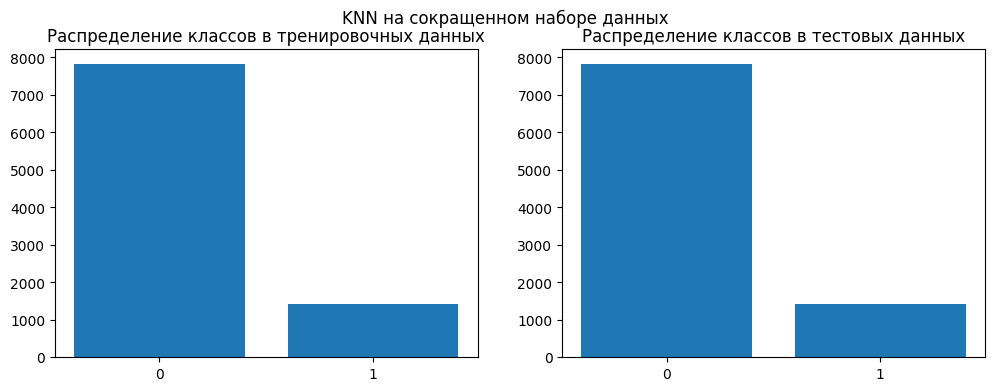

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2594
           1       0.69      0.46      0.55       489

    accuracy                           0.88      3083
   macro avg       0.80      0.71      0.74      3083
weighted avg       0.87      0.88      0.87      3083

Balanced Accuracy: 0.7104005941034288


In [219]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_sign, knn_sign_data, knn_sign_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на сокращенном наборе данных')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


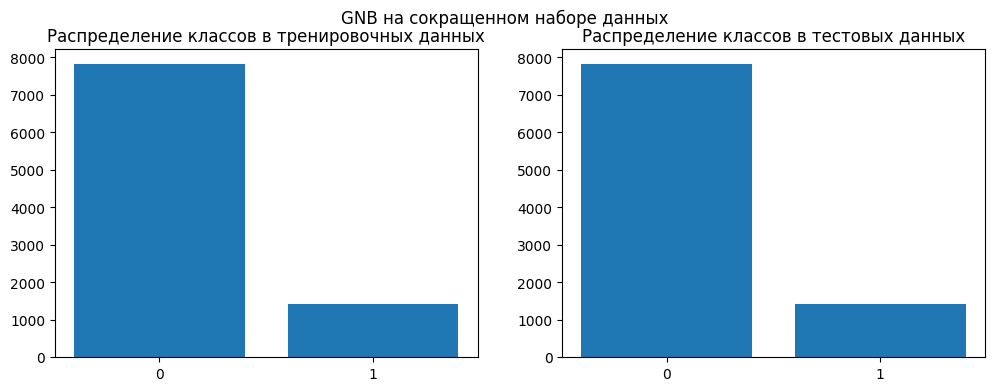

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2594
           1       0.56      0.73      0.63       489

    accuracy                           0.87      3083
   macro avg       0.75      0.81      0.78      3083
weighted avg       0.88      0.87      0.87      3083

Balanced Accuracy: 0.8095932409698013


In [220]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb = GaussianNB()
gnb_sign, gnb_sign_data, gnb_sign_metrics = get_train_report(gnb, X_train, X_test, y_train, y_test, 'GNB на сокращенном наборе данных')

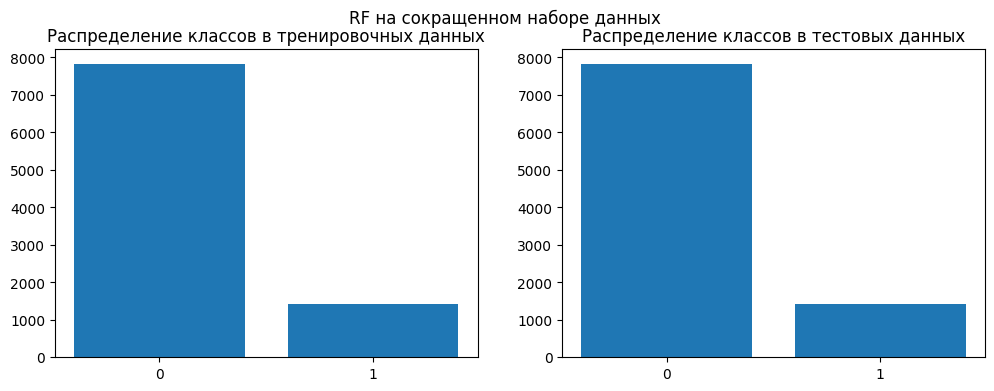

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2594
           1       0.67      0.53      0.59       489

    accuracy                           0.88      3083
   macro avg       0.79      0.74      0.76      3083
weighted avg       0.88      0.88      0.88      3083

Balanced Accuracy: 0.7388798753770303


In [221]:
from sklearn.ensemble import RandomForestClassifier

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

rf = RandomForestClassifier()
rf_sign, rf_sign_data, rf_sign_metrics = get_train_report(rf, X_train, X_test, y_train, y_test, 'RF на сокращенном наборе данных')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


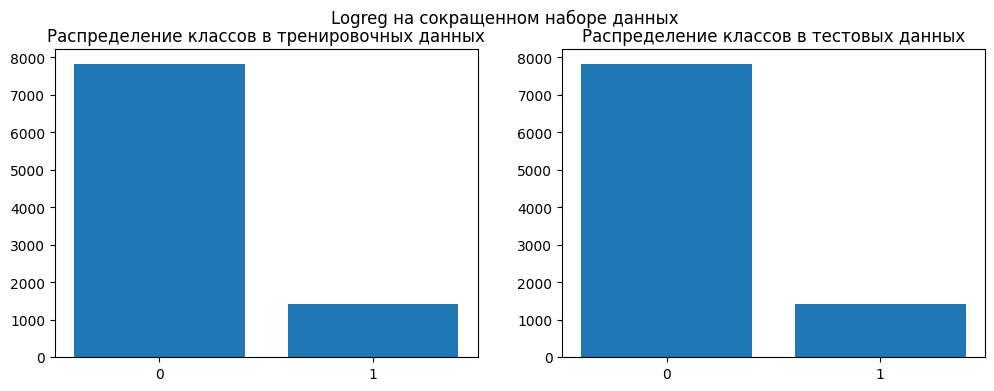

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2594
           1       0.67      0.52      0.58       489

    accuracy                           0.88      3083
   macro avg       0.79      0.73      0.76      3083
weighted avg       0.87      0.88      0.88      3083

Balanced Accuracy: 0.7341529059509675


In [222]:
from sklearn.linear_model import LogisticRegression

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

lr = LogisticRegression()
lr_sign, lr_sign_data, lr_sign_metrics = get_train_report(lr, X_train, X_test, y_train, y_test, 'Logreg на сокращенном наборе данных')

**Обучение базового алгоритма на всем наборе данных.**

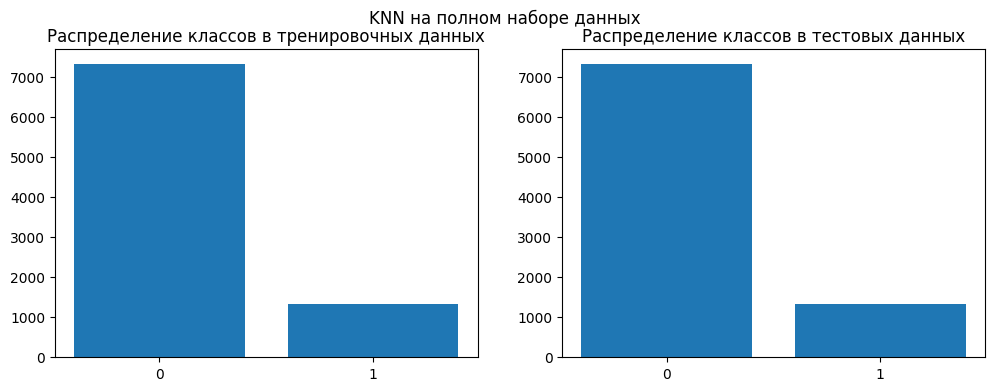

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2460
           1       0.50      0.19      0.27       429

    accuracy                           0.85      2889
   macro avg       0.69      0.58      0.60      2889
weighted avg       0.82      0.85      0.82      2889

Balanced Accuracy: 0.5781454318039684


In [230]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_all, knn_all_data, knn_all_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на полном наборе данных')

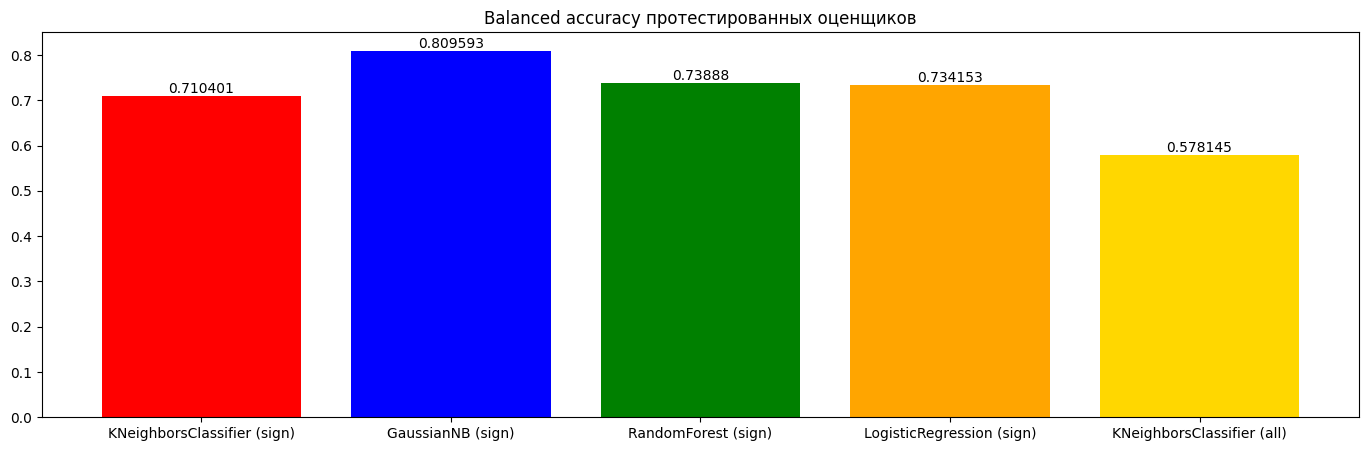

In [242]:
estimators = ['KNeighborsClassifier (sign)', 'GaussianNB (sign)', 'RandomForest (sign)', 'LogisticRegression (sign)', 'KNeighborsClassifier (all)']
balanced_accuracy = [knn_sign_metrics[1], gnb_sign_metrics[1], rf_sign_metrics[1], lr_sign_metrics[1], knn_all_metrics[1]]

plt.figure(figsize=(17, 5))

bar = plt.bar(estimators, balanced_accuracy, color = ['red', 'blue', 'green', 'orange', 'gold'])
plt.bar_label(bar)

plt.title('Balanced accuracy протестированных оценщиков');

Imbalansing
Рассмотрен лучший алгоритм и методы устранения дисбаланса классов в обучающей выборке. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


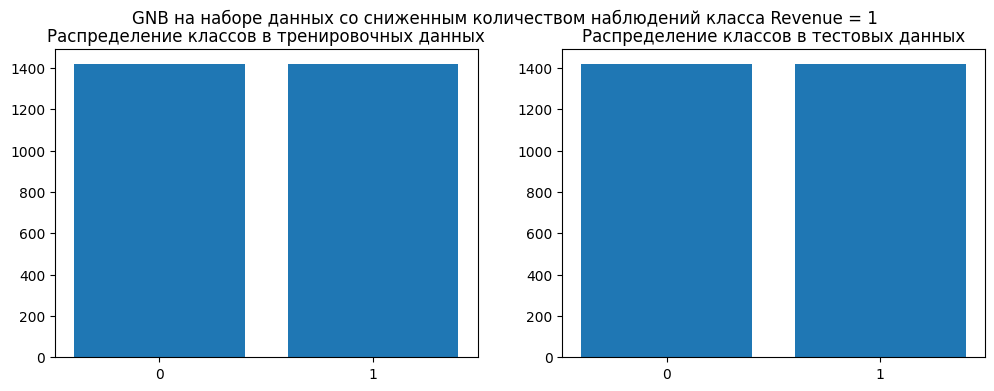

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Balanced Accuracy: 0.8261053114549385


In [248]:
RUS = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)
X_resampled, y_resampled = RUS.fit_resample(X_train, y_train)

gnb = GaussianNB()
gnb_rus_sign, gnb_rus_sign_data, gnb_rus_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test, 
                                                                         'GNB на наборе данных cо сниженным количеством наблюдений класса Revenue = 1')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


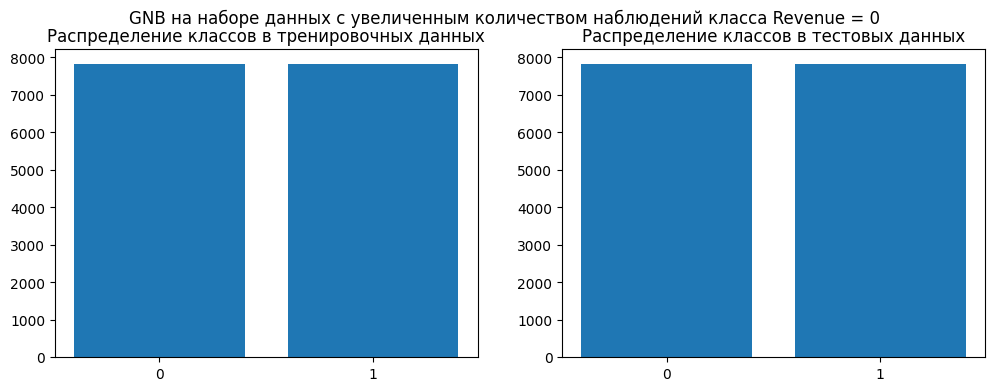

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Balanced Accuracy: 0.8266835689722862


In [251]:
ROS = RandomOverSampler(random_state=42)

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)


X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)
X_resampled, y_resampled = ROS.fit_resample(X_train, y_train)


gnb = GaussianNB()
gnb_ros_sign, gnb_ros_sign_data, gnb_ros_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test, 'GNB на наборе данных c увеличенным количеством наблюдений класса Revenue = 0')

Подбор гиперпараметров. 

In [255]:
knn_params = {'n_neighbors': range(2, 10, 2),
              'weights' : ['uniform', 'distance'],
              'metric' : ['minkowski', 'euclidean', 'manhattan'],
              'p' : [1, 2]
    
}
knn = KNeighborsClassifier()

In [256]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gs = GridSearchCV(knn, param_grid=knn_params, cv=3, scoring='balanced_accuracy')

In [257]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': range(2, 10, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [258]:
predictions = gs.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(clf_report)
print(f'Balanced Accuracy: {balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2594
           1       0.65      0.46      0.54       489

    accuracy                           0.88      3083
   macro avg       0.78      0.71      0.73      3083
weighted avg       0.86      0.88      0.87      3083

Balanced Accuracy: 0.707568038875303


In [259]:
rf_params = {'n_estimators': range(70, 130, 20),
              'criterion' : ['gini', 'entropy'],
              'min_samples_split' : range(2, 8, 2),
              'max_depth' : range(4, 7)
    
}
rf = RandomForestClassifier()

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gs = GridSearchCV(rf, param_grid=rf_params, cv=3, scoring='balanced_accuracy')

gs.fit(X_train, y_train)

predictions = gs.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(clf_report)
print(f'Balanced Accuracy: {balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2594
           1       0.72      0.48      0.58       489

    accuracy                           0.89      3083
   macro avg       0.81      0.72      0.76      3083
weighted avg       0.88      0.89      0.88      3083

Balanced Accuracy: 0.7225530680365102
